In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import math
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

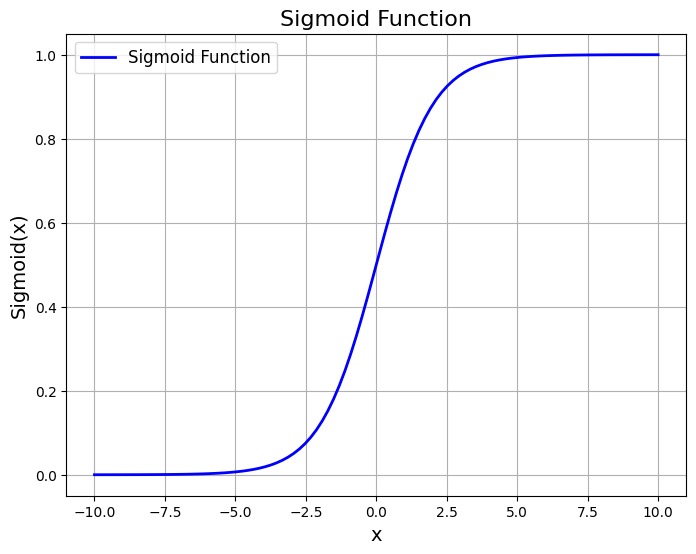

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-10, 10, 100)
y = sigmoid(x)
plt.figure(figsize = (8,6))
plt.plot(x, y, label='Sigmoid Function', color='blue', linewidth=2)
plt.title('Sigmoid Function', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Sigmoid(x)', fontsize=14)
plt.grid()
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [4]:
raisins = pd.read_csv('./data/raisin_dataset.csv')
print(raisins.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    float64
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(6), int64(1), object(1)
memory usage: 56.4+ KB
None


In [5]:
pd.set_option('display.max_columns', None)
print(raisins.head(n=3))
print(raisins.tail(n=3))

    Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  Extent  \
0  87524           442.25           253.29          0.82     90546.0    0.76   
1  75166           406.69           243.03          0.80     78789.0    0.68   
2  90856           442.27           266.33          0.80     93717.0    0.64   

   Perimeter    Class  
0    1184.04  Kecimen  
1    1121.79  Kecimen  
2    1208.58  Kecimen  
      Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
897  99657           431.71           298.84          0.72    106264.0   
898  93523           476.34           254.18          0.85     97653.0   
899  85609           512.08           215.27          0.91     89197.0   

     Extent  Perimeter  Class  
897    0.74    1292.83  Besni  
898    0.66    1258.55  Besni  
899    0.63    1272.86  Besni  


In [6]:
class_mapping = {'Kecimen': 0, 'Besni': 1}
raisins['Class'] = raisins['Class'].map(class_mapping)

print(raisins[['Area', 'MajorAxisLength', 'Class']].head(n=3))
print(raisins[['Area', 'MajorAxisLength', 'Class']].tail(n=3))

    Area  MajorAxisLength  Class
0  87524           442.25      0
1  75166           406.69      0
2  90856           442.27      0
      Area  MajorAxisLength  Class
897  99657           431.71      1
898  93523           476.34      1
899  85609           512.08      1


In [7]:
basic_statistics = (raisins.groupby('Class') \
                    .agg(['min', 'max', 'mean', 'median', 'std', 'var']))
print(basic_statistics.round(2))

        Area                                                       \
         min     max       mean    median       std           var   
Class                                                               
0      25387  180898   63413.47   61420.0  17727.77  3.142738e+08   
1      40702  235047  112194.79  104426.5  39229.90  1.538985e+09   

      MajorAxisLength                                            \
                  min     max    mean  median     std       var   
Class                                                             
0              225.63  843.96  352.86  350.24   59.61   3553.54   
1              274.17  997.29  509.00  493.19  105.77  11187.53   

      MinorAxisLength                                         Eccentricity  \
                  min     max    mean  median    std      var          min   
Class                                                                        
0              143.71  326.90  229.35  228.62  34.06  1159.96         0.35   
1     

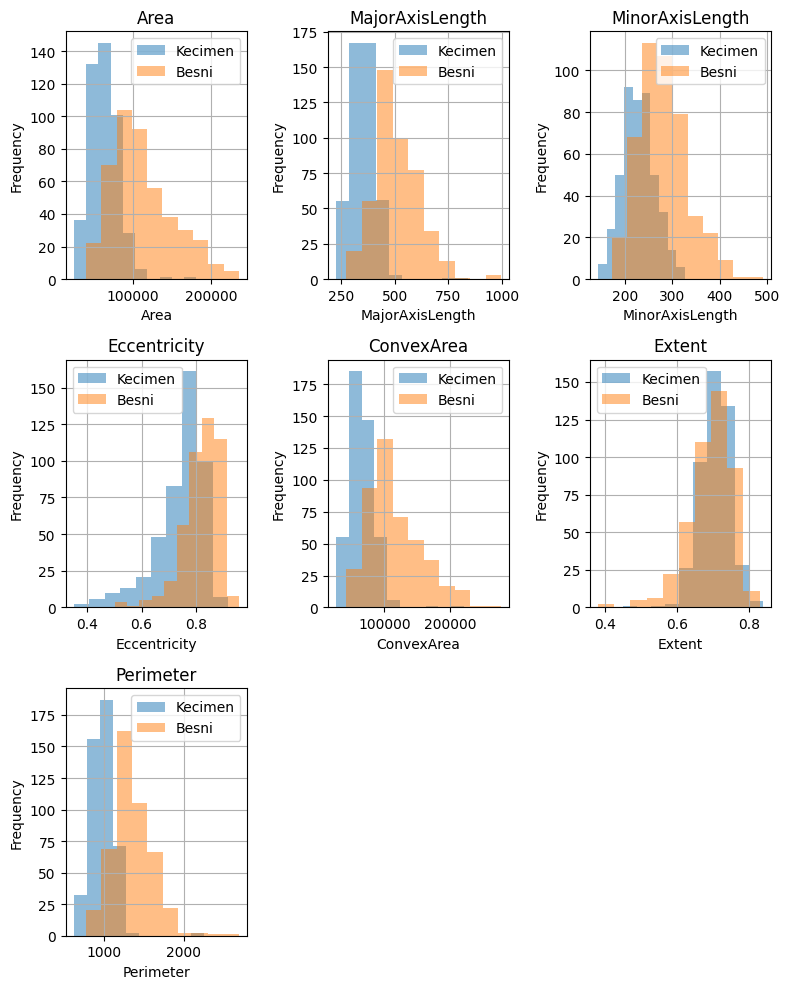

In [8]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), \
      (ax7, ax8, ax9)) = plt.subplots(nrows = 3, \
                                      ncols = 3, figsize = (8, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
columns = ['Area', 'MajorAxisLength', 'MinorAxisLength', \
           'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']

for i, column in enumerate(columns):
    for class_label, data in raisins.groupby('Class'):
        (data[column] \
         .hist(alpha=0.5, label = class_label, ax = axes[i]))
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].legend(labels = ['Kecimen', 'Besni'])

for ax in [ax8, ax9]:
    ax.axis('off')

plt.tight_layout()
plt.show()

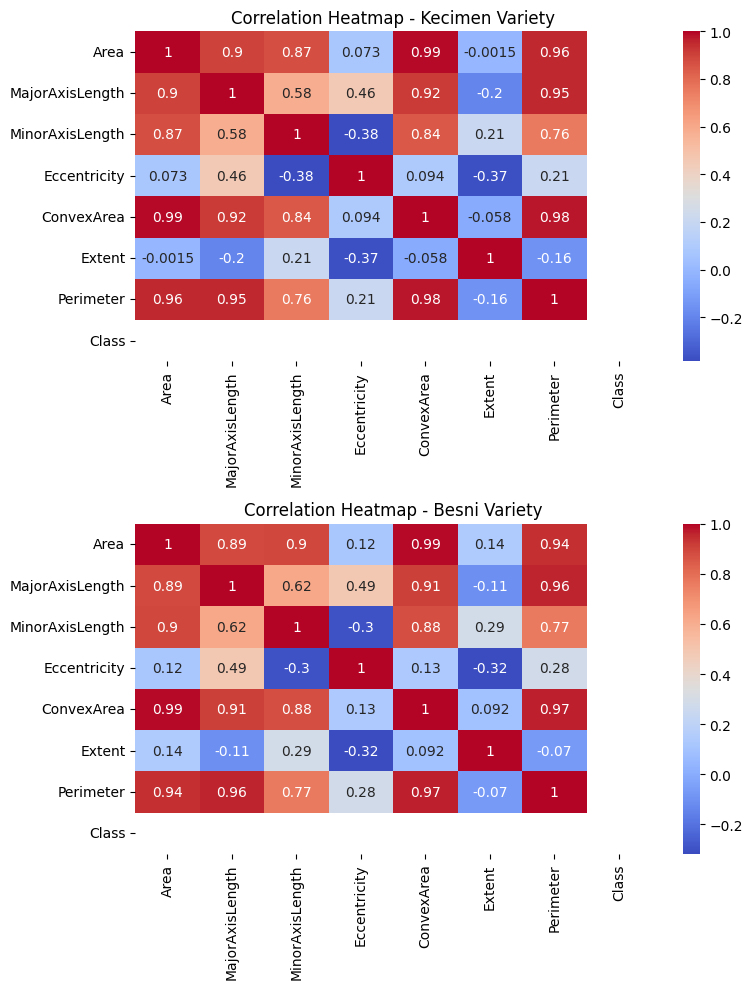

In [9]:
class_0_data = raisins[raisins['Class'] == 0]
class_1_data = raisins[raisins['Class'] == 1]

correlation_matrix_class_0 = class_0_data.corr()
correlation_matrix_class_1 = class_1_data.corr()

fig, axs = plt.subplots(2, 1, figsize=(8,10))
sns.heatmap(correlation_matrix_class_0, \
            annot = True, cmap='coolwarm', ax=axs[0])
axs[0].set_title('Correlation Heatmap - Kecimen Variety')
sns.heatmap(correlation_matrix_class_1, \
            annot = True, cmap='coolwarm', ax=axs[1])
axs[1].set_title('Correlation Heatmap - Besni Variety')
plt.tight_layout()
plt.show()


In [10]:
log_model = smf.logit('Class ~ Area + '
                  'MajorAxisLength + '
                  'MinorAxisLength + '
                  'Eccentricity + '
                  'ConvexArea + '
                  'Extent + '
                  'Perimeter', data = raisins).fit()
print(log_model.summary())

Optimization terminated successfully.
         Current function value: 0.338384
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                  900
Model:                          Logit   Df Residuals:                      892
Method:                           MLE   Df Model:                            7
Date:                Fri, 14 Nov 2025   Pseudo R-squ.:                  0.5118
Time:                        15:35:02   Log-Likelihood:                -304.55
converged:                       True   LL-Null:                       -623.83
Covariance Type:            nonrobust   LLR p-value:                1.196e-133
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.6642      7.028     -0.379      0.705     -16.439      11.111
Area          

In [11]:
y = raisins['MinorAxisLength']
x = raisins[['Area', 'MajorAxisLength', 'ConvexArea', 'Extent', \
             'Eccentricity', 'Perimeter']]
x = sm.add_constant(x)

multicollinearity_test = sm.OLS(y, x).fit()
r2 = multicollinearity_test.rsquared
print(r2)

y, X = dmatrices('Class ~ Area + '
                 'MajorAxisLength + '
                 'MinorAxisLength + '
                 'ConvexArea + '
                 'Extent + '
                 'Eccentricity + '
                 'Perimeter',
                 data = raisins, return_type = 'dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns

vif_df['VIF'] = [variance_inflation_factor(X.values, i) \
                 for i in range(X.shape[1])]

print(vif_df)

0.9751270231122477
          variable          VIF
0        Intercept  1117.154039
1             Area   404.773424
2  MajorAxisLength   129.289901
3  MinorAxisLength    40.204275
4       ConvexArea   446.016527
5           Extent     1.600679
6     Eccentricity     5.194067
7        Perimeter   184.388548


In [12]:
reduced_model = smf.logit('Class ~ MinorAxisLength + Perimeter', \
                          data = raisins).fit()
print(reduced_model.summary())

Optimization terminated successfully.
         Current function value: 0.346417
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                  900
Model:                          Logit   Df Residuals:                      897
Method:                           MLE   Df Model:                            2
Date:                Fri, 14 Nov 2025   Pseudo R-squ.:                  0.5002
Time:                        15:41:35   Log-Likelihood:                -311.78
converged:                       True   LL-Null:                       -623.83
Covariance Type:            nonrobust   LLR p-value:                2.987e-136
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -11.8048      0.878    -13.442      0.000     -13.526     -10.084
MinorAxisLengt

In [13]:
raisins_subset = raisins[['MinorAxisLength', 'Perimeter', 'Class']]

raisins_subset['probability'] = 1 / (1 + 2.72**(-(-11.8048 +
              (-.0244 * raisins_subset['MinorAxisLength']) +
              (.0159 * raisins_subset['Perimeter']))))

print(raisins_subset.head(n = 3))
print(raisins_subset.tail(n = 3))

raisins_subset['prediction'] = (raisins_subset['probability'] \
                                .apply(lambda x: 0 if x < 0.5 else 1))

print(raisins_subset.head(n = 3))
print(raisins_subset.tail(n = 3))

   MinorAxisLength  Perimeter  Class  probability
0           253.29    1184.04      0     0.698821
1           243.03    1121.79      0     0.525426
2           266.33    1208.58      0     0.713766
     MinorAxisLength  Perimeter  Class  probability
897           298.84    1292.83      1     0.811597
898           254.18    1258.55      1     0.881365
899           215.27    1272.86      1     0.960193
   MinorAxisLength  Perimeter  Class  probability  prediction
0           253.29    1184.04      0     0.698821           1
1           243.03    1121.79      0     0.525426           1
2           266.33    1208.58      0     0.713766           1
     MinorAxisLength  Perimeter  Class  probability  prediction
897           298.84    1292.83      1     0.811597           1
898           254.18    1258.55      1     0.881365           1
899           215.27    1272.86      1     0.960193           1


C:\Users\PauloOliveira\AppData\Local\Temp\ipykernel_35012\2681194831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raisins_subset['probability'] = 1 / (1 + 2.72**(-(-11.8048 +
C:\Users\PauloOliveira\AppData\Local\Temp\ipykernel_35012\2681194831.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raisins_subset['prediction'] = (raisins_subset['probability'] \


In [14]:
count = len(raisins_subset[(raisins_subset['Class'] == 0) &
                           (raisins_subset['prediction'] == 0)])
print(count)

count = len(raisins_subset[(raisins_subset['Class'] == 0) &
                           (raisins_subset['prediction'] == 1)])
print(count)


count = len(raisins_subset[(raisins_subset['Class'] == 1) &
                           (raisins_subset['prediction'] == 1)])
print(count)


count = len(raisins_subset[(raisins_subset['Class'] == 1) &
                           (raisins_subset['prediction'] == 0)])
print(count)


397
53
384
66


In [15]:
confusion_matrix = pd.crosstab(raisins_subset['Class'], \
                               raisins_subset['prediction'])
print(confusion_matrix)

prediction    0    1
Class               
0           397   53
1            66  384


In [16]:
tp = 384
tn = 397
fp = 53
fn = 66
n = 900

sensitivity = (tp / (tp + fn)) * 100
print(sensitivity)

tpr = recall_score(raisins_subset['Class'], raisins_subset['prediction'])
print(tpr * 100)

specificity = (tn / (tn + fp)) * 100
print(specificity)

tnr = recall_score(raisins_subset['Class'], \
                   raisins_subset['prediction'], pos_label=0)
print(tnr * 100)

false_positive_rate = (fp / (fp + tn)) * 100
print(false_positive_rate)

false_negative_rate = (fn / (tp + fn)) * 100
print(false_negative_rate)

accuracy = ((tp + tn) / n) * 100
print(accuracy)

misclassification_rate = ((fp + fn) / n) * 100
print(misclassification_rate)

auc = roc_auc_score(raisins_subset['Class'], raisins_subset['prediction'])
print(auc)

fpr, tpr, threasholds = roc_curve(raisins_subset['Class'], raisins_subset['prediction'])


85.33333333333334
85.33333333333334
88.22222222222223
88.22222222222223
11.777777777777777
14.666666666666666
86.77777777777777
13.222222222222221
0.8677777777777779


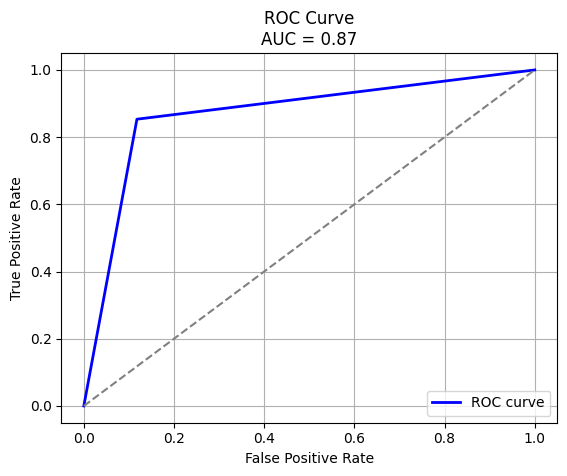

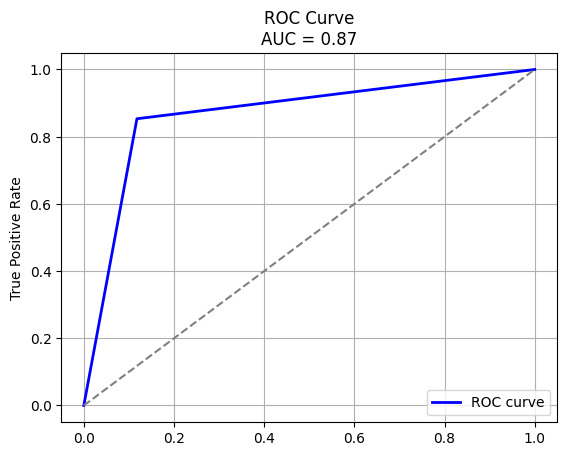

In [17]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color = 'blue', lw = 2, label = 'ROC curve')
ax.plot([0, 1], [0, 1], color = 'gray', linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve\nAUC = 0.87')
ax.legend(loc = 'lower right')
plt.grid()
plt.show()

fpr, tpr, thresholds = roc_curve(raisins_subset['Class'], \
                                 raisins_subset['prediction'])
plt.plot(fpr, tpr, color = 'blue', lw = 2, label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'gray', linestyle = '--')

plt.ylabel('True Positive Rate')
plt.title('ROC Curve\nAUC = 0.87')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()